### Training Word Embeddings with `TorchText`

In this notebook we are going to learn how we can train word embeddings, For that we are going to use pytorch with `torchtext` to train word embeddings using the news dataset which was obtained on  [kaggle](https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml).

### Installing Helper Packages
In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 3.0 MB/s eta 0:00:00


https://github.com/pytorch/text


Next we are going to install torchtext with the version of pytorch that matches it's requirements.

In [2]:
!pip install torch==2.3.0  torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/1

### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [3]:
import warnings
warnings.filterwarnings('ignore')

import json
import time
import torch
import os
import random
import torchtext
import spacy
import re
import en_core_web_sm
from google.colab import files

from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_wordcloud, plot_classification_report
from helperfns.utils import hms_string
from helperfns.text import clean_sentence
from torch import nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import torch.nn.functional as F

torch.__version__, torchtext.__version__

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


('2.3.0+cu121', '0.18.0+cpu')

### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

The dataset that we are going to use was founc on kaggle:

https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml


The dataset contains categories of news which are:

1. business
2. entertainment
3. education
4. sports
5. technology

In [7]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [8]:
!kaggle datasets download banuprakashv/news-articles-classification-dataset-for-nlp-and-ml --unzip

Dataset URL: https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml
License(s): apache-2.0
 72% 4.00M/5.57M [00:01<00:00, 4.25MB/s]
100% 5.57M/5.57M [00:01<00:00, 4.07MB/s]


Let's read our dataset into a pandas dataframes and then medge all the categories in `1` data frame that we will split later on.

In [9]:
business = pd.read_csv('business_data.csv')
entertainment = pd.read_csv('entertainment_data.csv')
education = pd.read_csv('education_data.csv')
sports = pd.read_csv('sports_data.csv')
technology = pd.read_csv('technology_data.csv')

merged = pd.concat([business, entertainment, education, sports, technology])

columns = ["class", "total"]
_data = [
    ["business", f"{len(business):,}"],
    ["entertainment", f"{len(entertainment):,}"],
    ["education", f"{len(education):,}"],
    ["sports", f"{len(sports):,}"],
    ["technology", f"{len(technology):,}"],
    ["TOTAL", f"{len(merged):,}"],
]
tabulate_data(columns, _data, title="Classes")

Classes
+---------------+--------+
| class         |  total |
+---------------+--------+
| business      |  2,000 |
| entertainment |  2,000 |
| education     |  2,000 |
| sports        |  2,000 |
| technology    |  2,000 |
| TOTAL         | 10,000 |
+---------------+--------+


In [10]:
merged.head(2)

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business


We are going to tripple our dataset by taking the `headlines`, `description` and `content`  and pair the text of these column to it's repective category.

In [11]:
news_dataset = []

for _, row in merged.iterrows():
  headlines, description, content, category= row.headlines, row.description, row.content, row.category
  news_dataset.append([headlines, category])
  news_dataset.append([description, category])
  news_dataset.append([content, category])

news_dataset = pd.DataFrame(news_dataset, columns=['text', 'category'])
news_dataset.head(2)

,text,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,business
1,With the presentation of the interim budget on...,business


In [12]:
print(f"New Dataset Size:\t {len(news_dataset):,}")

New Dataset Size:	 30,000


Next we are going to split our dataset into 3 subsets which are:

1. train
2. test
3. val

In [13]:
train_df, test_df = train_test_split(news_dataset, test_size=0.2, random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

### Data Analyisis

In this section of the notebook we are going to check how the data is distributed within our 3 sets.

First we are going to have a look at how the labels are distributed in the `training`, `validation` and `testing` subsets.

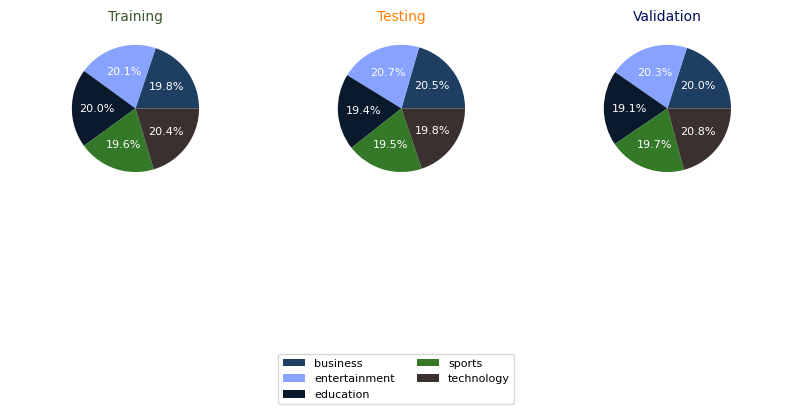

In [14]:
category_counts = news_dataset.category.value_counts()

train_dist_category	= {i:0 for i in train_df.category.unique()}
for val in train_df.category:
  train_dist_category[val] += 1

test_dist_category	= {i:0 for i in test_df.category.unique()}
for val in test_df.category:
  test_dist_category[val] += 1

val_dist_category	= {i:0 for i in valid_df.category.unique()}
for val in valid_df.category:
  val_dist_category[val] += 1


colors = ['#1E3E62', '#87A2FF', '#0B192C', '#347928', '#3B3030']
fig, axes = plt.subplots(1, 3, figsize=(8, 6))

axes[0].pie(train_dist_category.values(), labels=train_dist_category.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=1,
            colors=colors
            )
axes[0].set_title("Training", fontsize=10, color='#3C552D')

axes[1].pie(test_dist_category.values(), labels=test_dist_category.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=1,
            colors=colors
            )
axes[1].set_title("Testing", fontsize=10, color='#FF8000')

axes[2].pie(val_dist_category.values(), labels=val_dist_category.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=1,
            colors=colors)
axes[2].set_title("Validation", fontsize=10, color='#000B58')

fig.legend(category_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

We can see that among all the `3`  sets, classes are balanced.

In [15]:
train_text_counter = Counter()
for line in train_df.text:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_df.text:
    test_text_counter.update(line.lower().split())

valid_text_counter = Counter()
for line in valid_df.text:
    valid_text_counter.update(line.lower().split())

Next we are going to visualize the most common words in each set using word cloud plot.

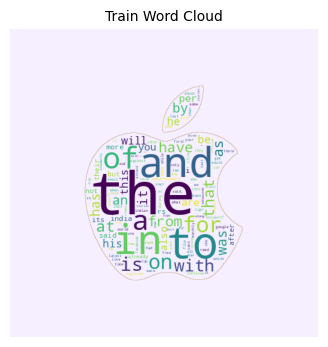

In [16]:
plot_wordcloud(train_text_counter, title="Train Word Cloud", mask="apple", background_color="#F5EFFF", figsize=(4, 4),
               fontsize=10)

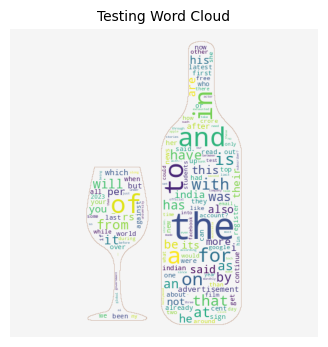

In [17]:
plot_wordcloud(test_text_counter, title="Testing Word Cloud", mask="wine", background_color="#F5F5F5", figsize=(4, 4),
               fontsize=10)

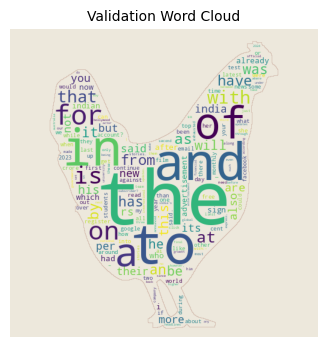

In [18]:
plot_wordcloud(valid_text_counter, title="Validation Word Cloud", mask="chicken", background_color="#EDE8DC", figsize=(4, 4),
               fontsize=10)

Next let's visualize how many examples are there in each `set`.

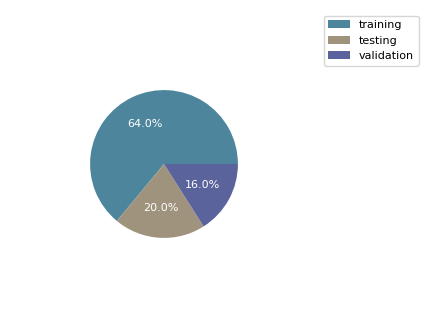

In [19]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(valid_df)], labels=['training', 'testing', 'validation'],
        autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#4D869C', '#A0937D', '#5A639C'])
plt.legend(fontsize=8, labels=['training', 'testing', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

``64%`` of the data is in the training set, ``20%`` in the test set and ``16%`` in the validation set. We can display this using a table:

In [20]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(train_df):,}"],
    ["TESTING", f"{len(test_df):,}"],
    ["VALIDATION", f"{len(valid_df):,}"],
    ["TOTAL", f"{len(test_df) + len(train_df) + len(valid_df):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+--------+
| Set        |  Total |
+------------+--------+
| TRAINING   | 19,200 |
| TESTING    |  6,000 |
| VALIDATION |  4,800 |
| TOTAL      | 30,000 |
+------------+--------+


### Features and Labels

Our fetures are the actual ``text`` in the dataframes which is the column named ``text`` and our labels will come from the column called `category`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [21]:
# train
train_texts = train_df.text.values
train_labels = train_df.category.values

# test
test_texts = test_df.text.values
test_labels = test_df.category.values

# val
val_texts = valid_df.text.values
val_labels = valid_df.category.values

### Text Preprocessing

In our text processing pipeline we need to do the following steps:
1. `text_cleaning`
- First we are going to remove punctuation url's and numbers, from the text. For that we are going to use a function called `clean_sentence`  which cleans the text, by removing punctuations, numbers, tags, urls, etc from a sentence.

2. ``tokenize sentences``
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from ``spacy`` language model.

3. ``vocabulary``
* We will to create a vocabulary based on our sentences that are in the train dataset. A ``vocabulary`` is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the ``spacy-en`` language model. The reason we are using the english langauge model it's because our ``text`` are in ``english``.

In [22]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

['This', 'is', 'a', 'boy', '.']

In [23]:
def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    sent = re.sub(
        r"(@|#)([A-Za-z0-9]+)", " ", sent
    )
    sent = re.sub(
        r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent
    )
    sent = re.sub(r"https?\S+", " ", sent, flags=re.MULTILINE)  # removing url's
    sent = re.sub(r"\d", " ", sent)  # removing none word characters
    sent = re.sub(
        r"[^\w\s\']", " ", sent
    )
    sent = re.sub(r"\s+", " ", sent).strip()  # remove more than one space
    return sent


### Vocabulary
In the following code cell we are going to create a vocabulary object from ``torchtext``.  So we are going to use the ``Counter`` module from collections to generate these counts from our ``train`` text.

We are going to specify the ``min_freq`` to ``2`` meaning that the words that does not appear at least ``2`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [24]:
counter = Counter()
for line in train_texts:
  line = clean_sentence(line)
  tokens = tokenizer(line)
  counter.update(tokens)

In [25]:
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [26]:
stoi = vocabulary.get_stoi()
print(f"Vocab Size:\t {len(stoi):,}")

Vocab Size:	 26,982


### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).


> Note that our `text_pipeline` should also do the same process during vocabulary creation.

In [27]:
def text_pipeline(x: str):
  values = list()
  x = clean_sentence(x)
  tokens = tokenizer(x)
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a ``labels_vocab`` which is a label to integer representation.

In [28]:
labels_dict = {k: v for v, k in enumerate(train_df.category.unique())}
labels_dict

{'business': 0,
 'entertainment': 1,
 'education': 2,
 'technology': 3,
 'sports': 4}

The ``label_pipeline`` function will then takes in the label and then returns us an integer representation of that label.

In [29]:
label_pipeline = lambda x: labels_dict[x]

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `NewsCategoryDataset`. This dataset will takes in the labels and the text of a set.

In [30]:
class NewsCategoryDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(NewsCategoryDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` and ``labels``. This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features`` and ``labels``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features and labels to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``labels`` and ``features``.

In [31]:
def tokenize_batch(batch, max_len=128, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  features = torch.cat(text_list, dim=0)
  return torch.LongTensor(labels_list), features

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `NewsCategoryDataset` class.

In [32]:
train_dataset = NewsCategoryDataset(train_labels, train_texts)
test_dataset = NewsCategoryDataset(test_labels, test_texts)
val_dataset = NewsCategoryDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data`` for our ``3`` sets. We are going to use the ``batch_size`` of ``64`` and our ``collate_function`` is ``tokenize_batch``. For the validation and testing dataset we are going to set the ``shuffle`` to ``False`` because there's no need fo us to shuffle these examples.

In [33]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [34]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [35]:
lbl

tensor([2, 0, 3, 0, 1, 2, 3, 4, 1, 1, 0, 2, 3, 0, 4, 3, 3, 1, 2, 3, 1, 3, 2, 2,
        3, 1, 4, 3, 0, 0, 1, 0, 0, 3, 4, 0, 4, 1, 4, 3, 4, 1, 2, 0, 0, 3, 0, 4,
        1, 4, 3, 3, 1, 1, 3, 1, 3, 2, 2, 4, 1, 0, 3, 0])

The first sentence in the batch.

In [36]:
txt[0]

tensor([  739,  7705,   739,  8701,   170,  6911,    17,   986,  4728,  1917,
        13298,   183,  2320,   818,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],

### Models.

Next we are going to create our model that does NewsCategory Detection based on the text provide.

### `NewsCategoryRNN`

In the following code cell we are going to build a model using `LSTM` and ``GRU`` layers.

In [37]:
class NewsCategoryRNN(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(NewsCategoryRNN, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )
    self.gru = nn.Sequential(
        nn.GRU(
                embedding_size, hidden_size,
                num_layers=num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True
        )
    )
    self.lstm = nn.Sequential(
            nn.LSTM(
                hidden_size * (2 if bidirectional else 1), hidden_size,
                num_layers=num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True
          )
    )
    self.linear = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=256),
        nn.Linear(256, out_features=256),
        nn.Linear(256, out_features=128),
    )
    self.out = nn.Sequential(
        nn.Linear(128, out_features=output_size)
    )
    self.dropout = nn.Dropout(dropout * .5)

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, _ = self.gru(packed_embedded)
    packed_output, (hidden, cell) = self.lstm(packed_output)
    if self.lstm[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    linear_out = self.linear(self.dropout(hidden))
    return self.out(self.dropout(linear_out))

In the following code cell we are going to create a model instance of the `NewsCategoryRNN` model.

In [38]:
INPUT_DIM = len(stoi)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
birnn = NewsCategoryRNN(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
birnn

NewsCategoryRNN(
  (embedding): Sequential(
    (0): Embedding(26982, 128, padding_idx=1)
  )
  (gru): Sequential(
    (0): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm): Sequential(
    (0): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (out): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

### Model Parameters

In the following code cell we are going to count parameters of each model achitecture and visualize it using a table.

In [39]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["bilstm", *count_trainable_params(birnn)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| bilstm |    8,613,893 |        8,613,893 |
+--------+--------------+------------------+


### Optimizer and Criterion
. For the ``optimizer`` we are going to use the ``Adam`` optimizer with default parameters and for the criterion we are going to use the ``CrossEntropyLoss()`` function since this is a multi-class classification.

In [40]:
optimizer = torch.optim.Adam(birnn.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our ``categorical_accuracy`` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [41]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Training and evaluation functions.

In the following code cell we are going to create our ``train`` and ``evalute`` functions:

In [42]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)



### Training Loop.

When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [43]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### 1. Training the `LSTM` model

The folloing code cell will run a training loop for the `ltsm` model for `20` epochs.

In [44]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [45]:
EPOCHS = 20

history, elt, last_saved_epoch = run_train_loop(
    birnn, 'embedding-model.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.899 |    0.649 | 0:00:40.22 |
| Validation | 0.522 |    0.833 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.347 |    0.888 | 0:00:40.81 |
| Validation | 0.325 |    0.899 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.206 |    0.938 | 0:00:40.64 |
| Validation | 0.315 |    0.907 |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Next we are going to check the the last saved epoch and the total training time the model took.

In [46]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "MODEL TRAINING TIME")

MODEL TRAINING TIME
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |          5 |
| TOTAL TRAINING TIME | 0:13:23.34 |
+---------------------+------------+


### Training History

In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

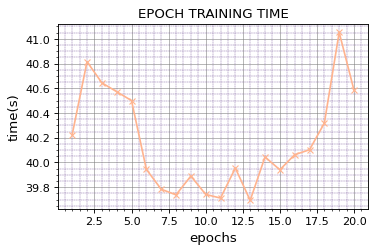

In [47]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, "x-", markerfacecolor = "#FFB38E", color='#FFB38E', label='lstm')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#4C1F7A', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for each model that was observed during model training.

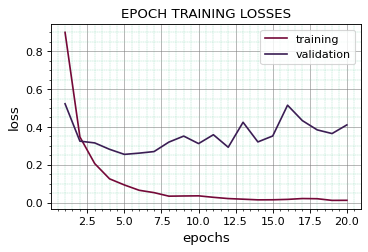

In [48]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#740938', label='training')
plt.plot(epochs, history.val_losses, color='#3B1E54', label='validation')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation accuracies using a line graph for each model that was observed during model training.

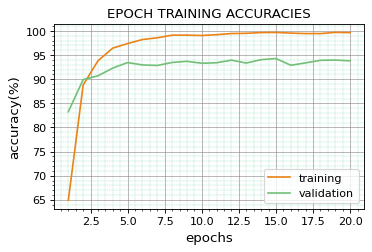

In [49]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color='#EB8317', label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color='#72BF78', label='validation')

plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.

In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [50]:
birnn.load_state_dict(torch.load('embedding-model.pt'))
birnn_test_loss, bistm_test_acc = evaluate(birnn, test_loader, criterion)

print(f'Test Loss: {birnn_test_loss:.3f} | Test Acc: {bistm_test_acc*100:.2f}%')


Test Loss: 0.255 | Test Acc: 93.51%


Next we are going to make predictions based with our test dataset for using our model.

In [51]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.softmax(y_pred, dim = -1)
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).argmax(1, keepdim = True).squeeze(1).numpy()
  return labels, predictions
y_true, y_preds = get_predictions(birnn, test_loader, device)

### Confusion matrix

In the following code cell we are going to plot the `Confusion Matrix` of our model.

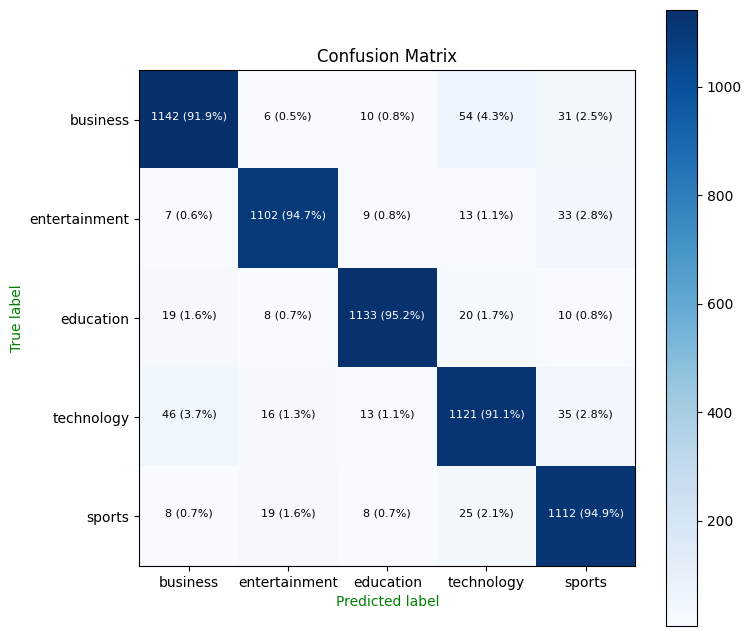

In [52]:
plot_complicated_confusion_matrix(y_true, y_preds,
  labels_dict.keys(), fontsize=8, figsize=(8, 8)
)

### Classification Report

Next we are going to plot the classification report of our model based on the test dataset.

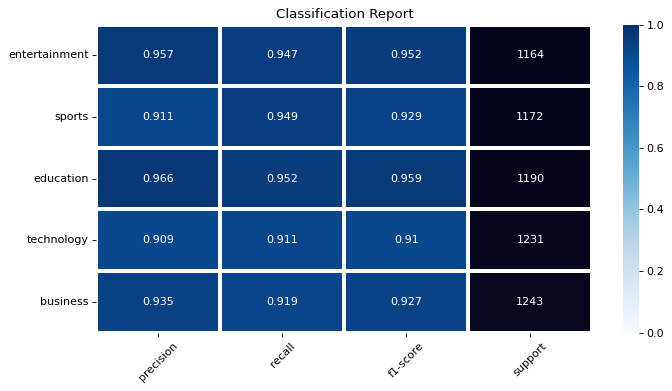

In [53]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
    )

### Saving model weights.

We are going to create a function called `write_embeddings` which will be responsible for writting our embeddings to a text file. We are going to use the `GloVe` naming convention. Our embeddings will be named:

``embeddings.26k.128d.txt``

Meaning our pretrained vectors were trainned with about `~26K` words and they are `128dim`

> Note that we are going to skip the special tokens.

In [54]:
special_tokens = ['[unk]', '[pad]', '[sos]', '[eos]']
def write_embeddings(path, embeddings, itos):
    with open(path, 'w') as f:
        for i, embedding in enumerate(embeddings):
            word = itos[i]
            # skip special tokens
            if word in special_tokens: continue
            #skip words with unicode symbols
            if len(word) != len(word.encode()):
                continue
            vector = ' '.join([str(i) for i in embedding.tolist()])
            f.write(f'{word} {vector}\n')

In [55]:
itos = vocabulary.get_itos()
weights = birnn.embedding[0].weight.data
write_embeddings('embeddings.26k.128d.txt', weights, itos)

In the following code cell we are going to load our saved custom word embeddings so that we see if they are correctlty loaded.

In [56]:
embeddings = vocab.Vectors(
    name = 'embeddings.26k.128d.txt',
    cache = 'custom_embeddings',
    unk_init = torch.Tensor.normal_
)

100%|█████████▉| 26859/26860 [00:02<00:00, 11028.23it/s]


The `get_vector` function takes in the embbedings and a word and returne `128` dimention vector embedding for that word if it does exists.

In [57]:
def get_vector(embedding, word):
    assert word in embedding.stoi, f'{word} not in the vocab'
    return embedding.vectors[embedding.stoi[word]]

get_vector(embeddings, 'the').shape

torch.Size([128])

Let's create a function called `closest_words` which get the closses words to of a given vector.

In [58]:
def closest_words(embeddings, vector, n = 10):
    distances = [(word, torch.dist(vector, get_vector(embeddings, word)).item())
                 for word in embeddings.itos]
    return sorted(distances, key = lambda w: w[1])[:n]

In [59]:
closest_words(embeddings, get_vector(embeddings, 'man'), n=5)

[('man', 0.0),
 ('counterpart', 12.331151008605957),
 ('markedly', 12.414912223815918),
 ('enforce', 12.547422409057617),
 ('undertake', 12.555115699768066)]

The `print_tuples` helper functions print tuples in a formated way.

In [60]:
def print_tuples(tuples):
    for w, d in tuples:
        print(f'({d:02.04f}) {w}')

In [61]:
print_tuples(closest_words(embeddings, get_vector(embeddings, 'man'), n=5))

(0.0000) man
(12.3312) counterpart
(12.4149) markedly
(12.5474) enforce
(12.5551) undertake


Let's create the `analogy` function that caculate the candidate words between from word vectors.

In [62]:
def analogy(embeddings, word1, word2, word3, n=5):
    #get vectors for each word
    word1_vector = get_vector(embeddings, word1)
    word2_vector = get_vector(embeddings, word2)
    word3_vector = get_vector(embeddings, word3)
    #calculate analogy vector
    analogy_vector = word2_vector - word1_vector + word3_vector
    #find closest words to analogy vector
    candidate_words = closest_words(embeddings, analogy_vector, n+3)
    #filter out words already in analogy
    candidate_words = [(word, dist) for (word, dist) in candidate_words
                       if word not in [word1, word2, word3]][:n]
    print(f'{word1} is to {word2} as {word3} is to...')
    return candidate_words

In [63]:
print_tuples(analogy(embeddings, 'man', 'king', 'woman'))

man is to king as woman is to...
(18.1950) definitive
(18.2977) townhouse
(18.3828) differs
(18.3868) manuel
(18.4062) girona


The ``plot_embeddings`` is used to plot the word embeddings.

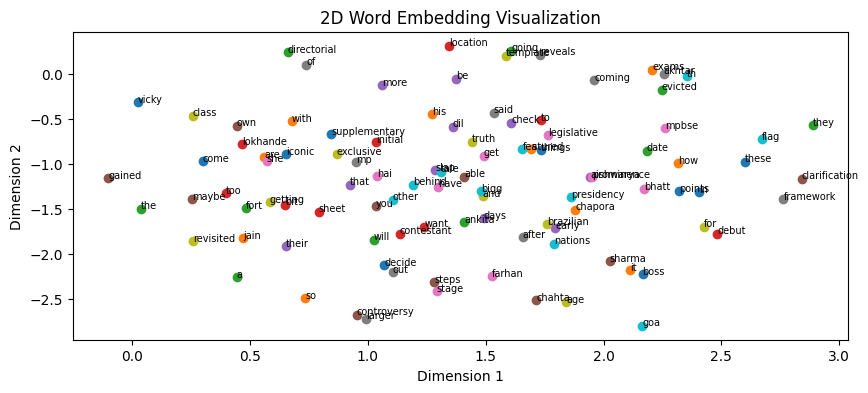

In [64]:
def get_plotable_data(embeddings, n_lower=0, n_upper=10):
  words = embeddings.itos[n_lower:n_upper]
  vectors = embeddings.vectors[n_lower:n_upper].numpy()
  tsne = TSNE(n_components=2, random_state=SEED, perplexity=(n_upper-n_lower)//2)
  reduced_embeddings = tsne.fit_transform(vectors)
  return words, reduced_embeddings


def plot_embeddings(reduced_embeddings, words):
  plt.figure(figsize=(10, 4))
  for i, word in enumerate(words):
      x, y = reduced_embeddings[i, 0], reduced_embeddings[i, 1]
      plt.scatter(x, y)
      plt.annotate(word, (x, y), fontsize=7)
  plt.title("2D Word Embedding Visualization")
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.show()


words, reduced_embeddings = get_plotable_data(embeddings, n_upper=100)
plot_embeddings(reduced_embeddings, words)
